In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057860 entries, 0 to 2057859
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.4 MB


# reduce to 1 million events

In [4]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [5]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,29380,0.12,29.380
1,29345,0.12,29.345
2,29255,0.12,29.255
3,29471,0.12,29.471
4,29330,0.12,29.330
...,...,...,...
999995,27575,0.13,27.575
999996,28118,0.13,28.118
999997,27599,0.13,27.599
999998,28258,0.13,28.258


In [6]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [7]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [8]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26059571042000

### Calcul de la date de base = now - cumul_interval

In [9]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 5, 28, 22, 34, 17, 648864)

In [10]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [11]:
conso_data.iloc[0]


Interval     29380.000000
kWh              0.120000
sec             29.380000
Wh             122.532335
cumul(ms)    29380.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [12]:
base

datetime.datetime(2024, 5, 28, 22, 34, 17, 648864)

## créer les dates

In [13]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-05-28 22:34:47.028864
1        2024-05-28 22:35:16.373864
2        2024-05-28 22:35:45.628864
3        2024-05-28 22:36:15.099864
4        2024-05-28 22:36:44.429864
                    ...            
999995   2025-03-26 13:18:36.428864
999996   2025-03-26 13:19:04.546864
999997   2025-03-26 13:19:32.145864
999998   2025-03-26 13:20:00.403864
999999   2025-03-26 13:20:28.690864
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [14]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,29380,0.12,29.380,122.532335,29380,2024-05-28 22:34:47.028864,28/05/24
1,29345,0.12,29.345,122.678480,58725,2024-05-28 22:35:16.373864,28/05/24
2,29255,0.12,29.255,123.055888,87980,2024-05-28 22:35:45.628864,28/05/24
3,29471,0.12,29.471,122.153982,117451,2024-05-28 22:36:15.099864,28/05/24
4,29330,0.12,29.330,122.741221,146781,2024-05-28 22:36:44.429864,28/05/24
...,...,...,...,...,...,...,...
999995,27575,0.13,27.575,130.553037,26059458780,2025-03-26 13:18:36.428864,26/03/25
999996,28118,0.13,28.118,128.031866,26059486898,2025-03-26 13:19:04.546864,26/03/25
999997,27599,0.13,27.599,130.439509,26059514497,2025-03-26 13:19:32.145864,26/03/25
999998,28258,0.13,28.258,127.397551,26059542755,2025-03-26 13:20:00.403864,26/03/25


### save conso_data with dates

In [15]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [16]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('26/03/25', 26, 3, 2025)

In [17]:
here = now.strftime('%H:%M:%S')
here

'13:20:45'

In [18]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [19]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 998345 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1655 non-null   int64         
 1   kWh        1655 non-null   float64       
 2   sec        1655 non-null   float64       
 3   Wh         1655 non-null   float64       
 4   cumul(ms)  1655 non-null   int64         
 5   dates      1655 non-null   datetime64[ns]
 6   days       1655 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 103.4+ KB


In [20]:
end = time.time()
print(end - start)

18.10546875


### grouped by days

In [21]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [22]:
data = list(df_grp['kWh'])
print(data)

[0.193, 3.092, 3.274, 4.142, 3.603, 4.256, 3.569, 3.313, 3.486, 3.181, 2.933, 3.41, 3.177, 3.307, 3.731, 3.36, 3.343, 3.095, 2.958, 3.696, 3.214, 3.127, 3.255, 3.357, 2.985, 3.035, 3.489, 3.638, 3.493, 3.043, 2.886, 2.079, 2.093, 2.085, 2.081, 2.085, 2.083, 2.08, 2.075, 2.112, 3.658, 3.137, 3.459, 3.798, 3.606, 3.795, 3.557, 3.652, 3.6, 3.486, 3.386, 3.282, 3.474, 3.29, 3.754, 3.671, 3.569, 3.598, 3.423, 3.23, 3.204, 2.853, 3.034, 3.686, 3.784, 3.766, 3.01, 3.358, 3.363, 3.505, 3.662, 3.693, 3.546, 3.702, 3.868, 3.801, 4.366, 4.217, 3.845, 3.966, 3.986, 3.826, 3.849, 3.716, 3.253, 3.972, 3.959, 4.408, 3.743, 4.183, 3.739, 3.965, 3.821, 3.902, 3.737, 3.59, 3.509, 3.712, 3.526, 4.071, 3.763, 3.39, 3.486, 3.297, 2.332, 1.795, 1.793, 1.792, 1.796, 2.528, 1.81, 1.789, 1.79, 1.791, 1.822, 1.822, 1.814, 1.817, 1.818, 1.818, 1.817, 1.81, 1.786, 1.786, 1.785, 1.786, 1.783, 1.797, 1.788, 1.789, 1.784, 1.797, 1.803, 1.794, 1.806, 1.794, 1.785, 1.789, 1.786, 1.79, 1.797, 1.791, 1.802, 1.803, 1.794

In [23]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [24]:
end = time.time()
print(end - start)

18.383657932281494


### plot function by day
#### show('dd/mm/yy')

In [25]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


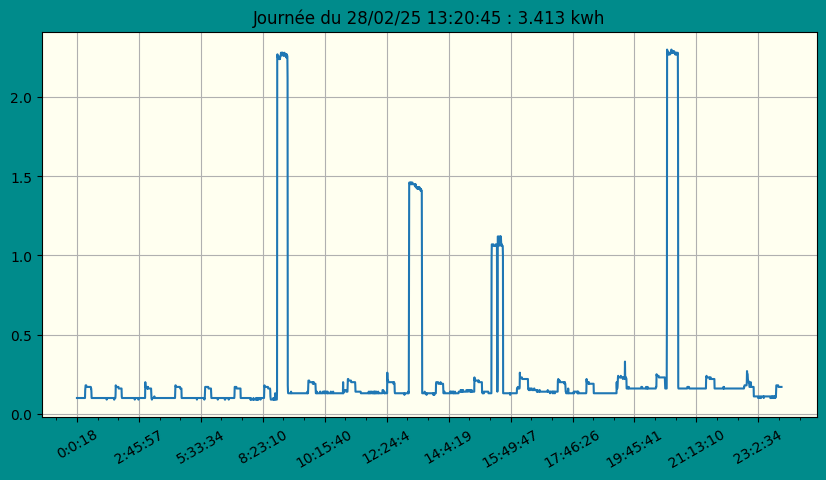

In [26]:
show('28/02/25')

In [27]:
end = time.time()
print(end - start)

20.247350692749023


### 1 kWh window in data of one day
#### df = conso_day

In [28]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998345,27226,0.13,27.226,132.226548,26011567584,2025-03-26 00:00:25.232864,26/03/25
998346,25512,0.14,25.512,141.110066,26011593096,2025-03-26 00:00:50.744864,26/03/25
998347,25993,0.14,25.993,138.498827,26011619089,2025-03-26 00:01:16.737864,26/03/25
998348,26553,0.14,26.553,135.577901,26011645642,2025-03-26 00:01:43.290864,26/03/25
998349,27112,0.13,27.112,132.782532,26011672754,2025-03-26 00:02:10.402864,26/03/25
...,...,...,...,...,...,...,...
999995,27575,0.13,27.575,130.553037,26059458780,2025-03-26 13:18:36.428864,26/03/25
999996,28118,0.13,28.118,128.031866,26059486898,2025-03-26 13:19:04.546864,26/03/25
999997,27599,0.13,27.599,130.439509,26059514497,2025-03-26 13:19:32.145864,26/03/25
999998,28258,0.13,28.258,127.397551,26059542755,2025-03-26 13:20:00.403864,26/03/25


In [29]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [30]:
df = conso_day
len(df)

1655

In [31]:
period()  # first kWh

2025-03-26 00:00:25.232864	2025-03-26 09:11:03.020864	9h 10m 37s 	1000


In [32]:
period(p=2) # second period

2025-03-26 09:11:03.020864	2025-03-26 13:20:28.690864	4h 9m 25s 	655


In [33]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.289618
dtype: float64

In [34]:
end = time.time()
print(end - start)

20.60613489151001


## mean for data grouped by days

In [35]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [36]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.655)

# conso by date


In [37]:
# select day
day = today

#day = '16/08/24'
day

'26/03/25'

In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998345,27226,0.13,27.226,132.226548,26011567584,2025-03-26 00:00:25.232864,26/03/25
998346,25512,0.14,25.512,141.110066,26011593096,2025-03-26 00:00:50.744864,26/03/25
998347,25993,0.14,25.993,138.498827,26011619089,2025-03-26 00:01:16.737864,26/03/25
998348,26553,0.14,26.553,135.577901,26011645642,2025-03-26 00:01:43.290864,26/03/25
998349,27112,0.13,27.112,132.782532,26011672754,2025-03-26 00:02:10.402864,26/03/25
...,...,...,...,...,...,...,...
999995,27575,0.13,27.575,130.553037,26059458780,2025-03-26 13:18:36.428864,26/03/25
999996,28118,0.13,28.118,128.031866,26059486898,2025-03-26 13:19:04.546864,26/03/25
999997,27599,0.13,27.599,130.439509,26059514497,2025-03-26 13:19:32.145864,26/03/25
999998,28258,0.13,28.258,127.397551,26059542755,2025-03-26 13:20:00.403864,26/03/25


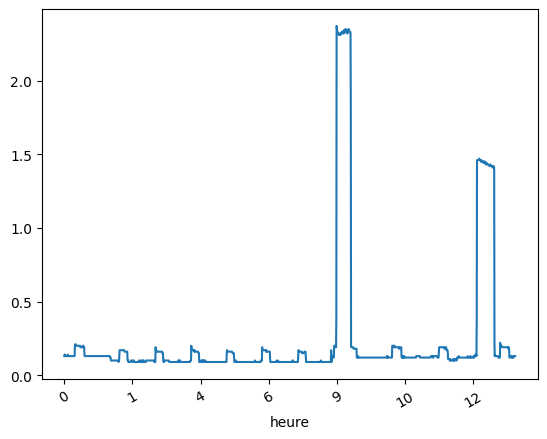

In [39]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [40]:
end = time.time()
print(end - start)

21.523367643356323


### grouped by 'heure'

In [41]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 998345 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1655 non-null   int64         
 1   kWh        1655 non-null   float64       
 2   sec        1655 non-null   float64       
 3   Wh         1655 non-null   float64       
 4   cumul(ms)  1655 non-null   int64         
 5   dates      1655 non-null   datetime64[ns]
 6   days       1655 non-null   object        
 7   heure      1655 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 116.4+ KB


In [42]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,27226,0.13,27.226,132.226548,26011567584,2025-03-26 00:00:25.232864,26/03/25
0,25512,0.14,25.512,141.110066,26011593096,2025-03-26 00:00:50.744864,26/03/25
0,25993,0.14,25.993,138.498827,26011619089,2025-03-26 00:01:16.737864,26/03/25
0,26553,0.14,26.553,135.577901,26011645642,2025-03-26 00:01:43.290864,26/03/25
0,27112,0.13,27.112,132.782532,26011672754,2025-03-26 00:02:10.402864,26/03/25
...,...,...,...,...,...,...,...
13,27575,0.13,27.575,130.553037,26059458780,2025-03-26 13:18:36.428864,26/03/25
13,28118,0.13,28.118,128.031866,26059486898,2025-03-26 13:19:04.546864,26/03/25
13,27599,0.13,27.599,130.439509,26059514497,2025-03-26 13:19:32.145864,26/03/25


In [43]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [44]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     143
1     117
2     107
3      94
4     106
5     105
6     106
7     103
8      93
9     178
10    134
11    133
12    182
13     54
Name: kWh, dtype: int64

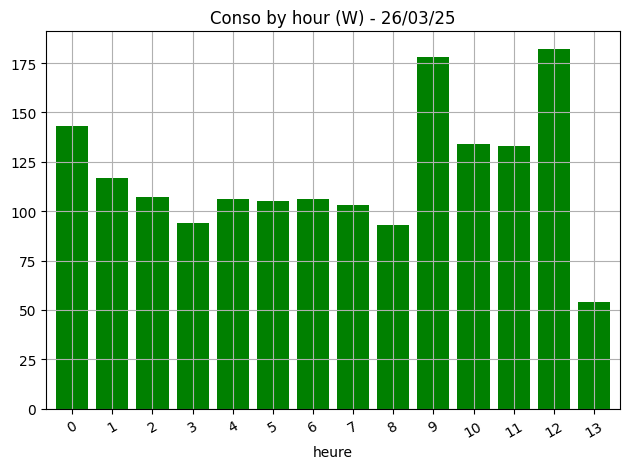

In [45]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [46]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 28/05/24 to 26/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [47]:
# give the periods of 1 kwh in a day
period()

2025-03-26 00:00:25.232864	2025-03-26 09:11:03.020864	9h 10m 37s 	1000


In [48]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-03-26 00:00:25.232864'),
 Timestamp('2025-03-26 09:11:04.555864'))

In [49]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [50]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [51]:
df_grp.head()


,kWh
days,
28/05/24,0.193
29/05/24,3.092
30/05/24,3.274
31/05/24,4.142
01/06/24,3.603


In [52]:
df_grp.tail()


,kWh
days,
22/03/25,4.206
23/03/25,3.673
24/03/25,3.476
25/03/25,3.870
26/03/25,1.655


In [53]:
end = time.time()
print(end - start)

22.875731468200684


# plot les 100 derniers jours


In [54]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.66352
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

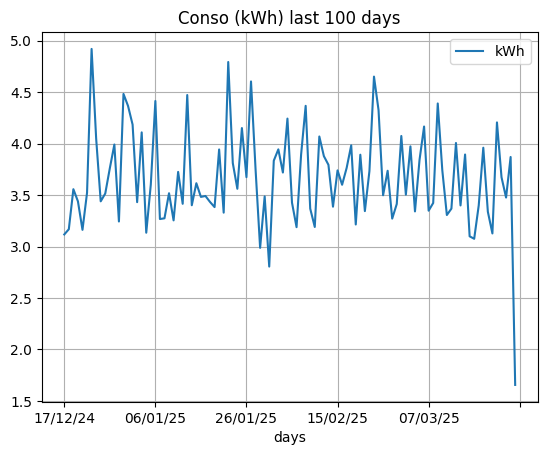

In [55]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [56]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.655
max,4.920


In [57]:
end = time.time()
print(end - start)

23.507996559143066


Text(0.5, 1.0, 'Last month conso by day')

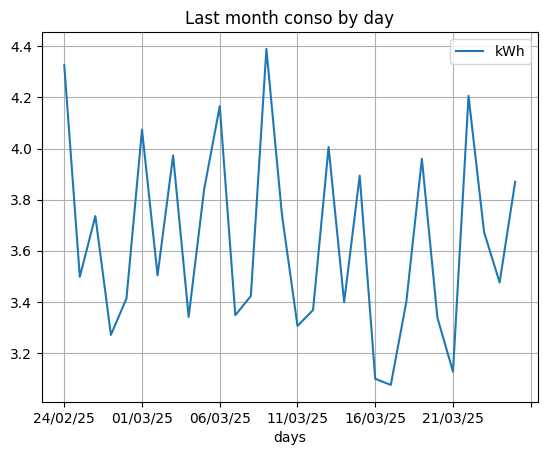

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/03/25 4.39
Min : 17/03/25 3.075


In [60]:

tranches = len(df)//1000
tranches+1


2

In [61]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-26 00:00:25.232864	2025-03-26 09:11:03.020864	9h 10m 37s 	1000
2025-03-26 09:11:03.020864	2025-03-26 13:20:28.690864	4h 9m 25s 	655


('13:20:45', 1.655, 1655)

In [62]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 998345 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1655 non-null   int64         
 1   kWh        1655 non-null   float64       
 2   sec        1655 non-null   float64       
 3   Wh         1655 non-null   float64       
 4   cumul(ms)  1655 non-null   int64         
 5   dates      1655 non-null   datetime64[ns]
 6   days       1655 non-null   object        
 7   heure      1655 non-null   object        
 8   hours      1655 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 129.3+ KB


In [63]:
conso_hours['heure'], conso_hours['hours']

(998345     0
 998346     0
 998347     0
 998348     0
 998349     0
           ..
 999995    13
 999996    13
 999997    13
 999998    13
 999999    13
 Name: heure, Length: 1655, dtype: object,
 998345    00
 998346    00
 998347    00
 998348    00
 998349    00
           ..
 999995    13
 999996    13
 999997    13
 999998    13
 999999    13
 Name: hours, Length: 1655, dtype: object)

In [64]:
end = time.time()
print(end - start)

24.54499840736389


# select number of days to display


In [65]:
span = 30
#df_grp.tail(span)

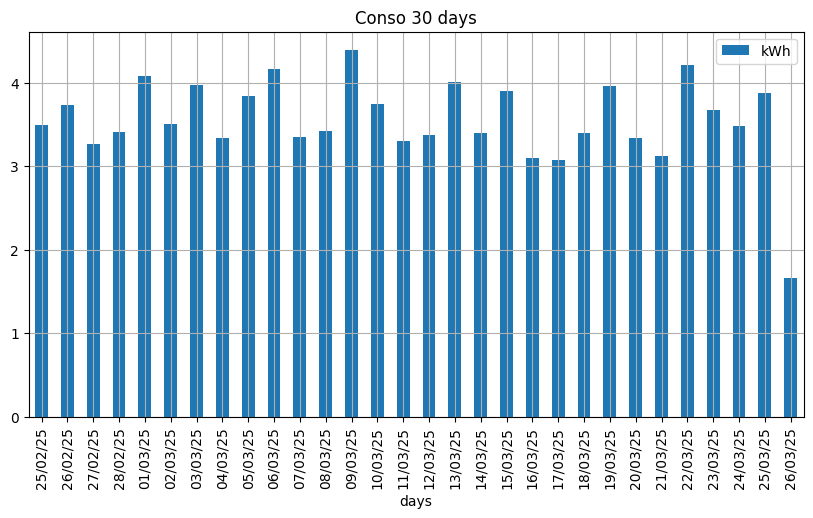

In [66]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


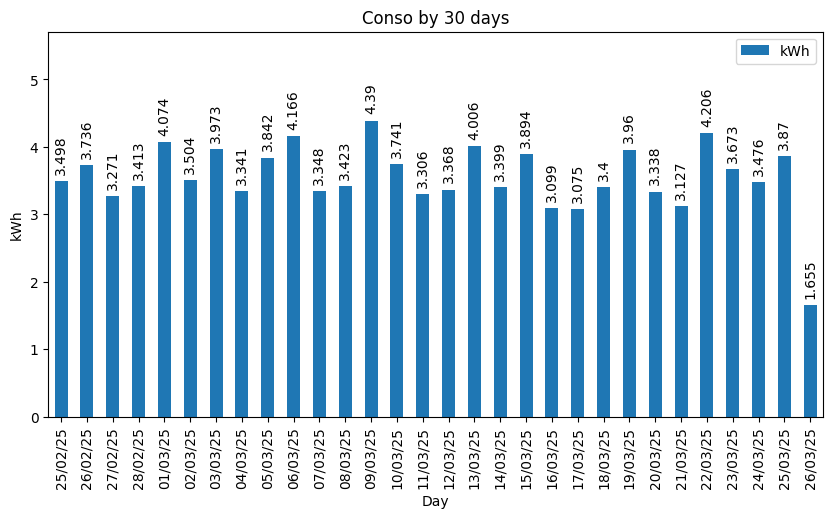

In [67]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [68]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
25/02/25    3.498
26/02/25    3.736
27/02/25    3.271
28/02/25    3.413
01/03/25    4.074
02/03/25    3.504
03/03/25    3.973
04/03/25    3.341
05/03/25    3.842
06/03/25    4.166
07/03/25    3.348
08/03/25    3.423
09/03/25    4.390
10/03/25    3.741
11/03/25    3.306
12/03/25    3.368
13/03/25    4.006
14/03/25    3.399
15/03/25    3.894
16/03/25    3.099
17/03/25    3.075
18/03/25    3.400
19/03/25    3.960
20/03/25    3.338
21/03/25    3.127
22/03/25    4.206
23/03/25    3.673
24/03/25    3.476
25/03/25    3.870
26/03/25    1.655
Name: kWh, dtype: float64

In [69]:
x_labels=df_grp.tail(span).index
x_labels

Index(['25/02/25', '26/02/25', '27/02/25', '28/02/25', '01/03/25', '02/03/25',
       '03/03/25', '04/03/25', '05/03/25', '06/03/25', '07/03/25', '08/03/25',
       '09/03/25', '10/03/25', '11/03/25', '12/03/25', '13/03/25', '14/03/25',
       '15/03/25', '16/03/25', '17/03/25', '18/03/25', '19/03/25', '20/03/25',
       '21/03/25', '22/03/25', '23/03/25', '24/03/25', '25/03/25', '26/03/25'],
      dtype='object', name='days')

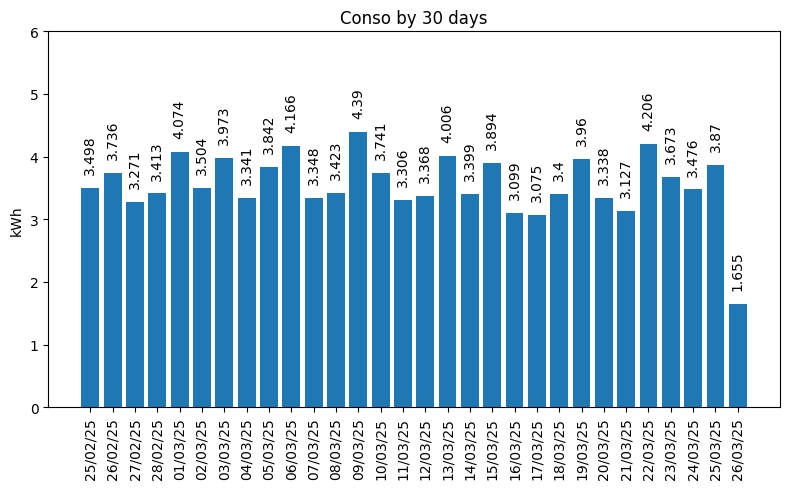

In [70]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [71]:
end = time.time()
print(end - start)

28.74140477180481


In [72]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

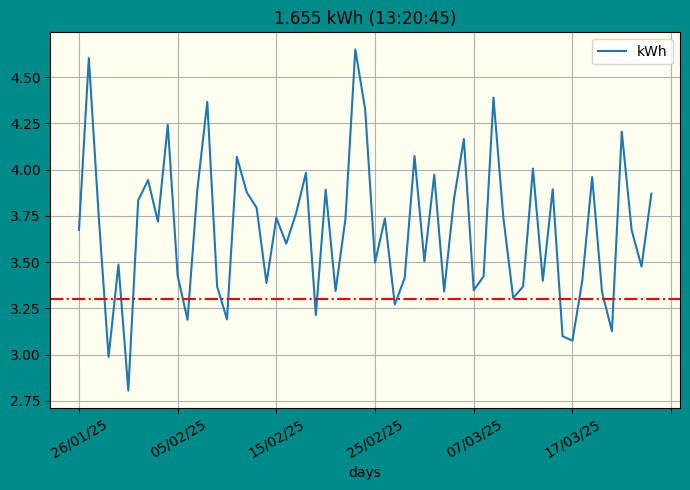

In [73]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

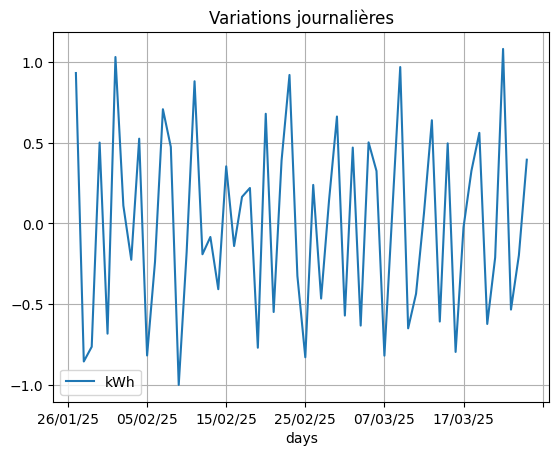

In [74]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [75]:
end = time.time()
print(end - start)

30.018397569656372


# Data from 21/08/23

In [76]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,29380,0.12,29.380,122.532335,29380,2024-05-28 22:34:47.028864,28/05/24,22,2024-05,28
1,29345,0.12,29.345,122.678480,58725,2024-05-28 22:35:16.373864,28/05/24,22,2024-05,28
2,29255,0.12,29.255,123.055888,87980,2024-05-28 22:35:45.628864,28/05/24,22,2024-05,28
3,29471,0.12,29.471,122.153982,117451,2024-05-28 22:36:15.099864,28/05/24,22,2024-05,28
4,29330,0.12,29.330,122.741221,146781,2024-05-28 22:36:44.429864,28/05/24,22,2024-05,28
...,...,...,...,...,...,...,...,...,...,...
999995,27575,0.13,27.575,130.553037,26059458780,2025-03-26 13:18:36.428864,26/03/25,13,2025-03,26
999996,28118,0.13,28.118,128.031866,26059486898,2025-03-26 13:19:04.546864,26/03/25,13,2025-03,26
999997,27599,0.13,27.599,130.439509,26059514497,2025-03-26 13:19:32.145864,26/03/25,13,2025-03,26
999998,28258,0.13,28.258,127.397551,26059542755,2025-03-26 13:20:00.403864,26/03/25,13,2025-03,26


In [77]:
end = time.time()
print(end - start)

68.96765995025635


In [78]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

# define month to show

In [79]:
month=conso_grouped_by_month.get_group('2025-02')

In [80]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

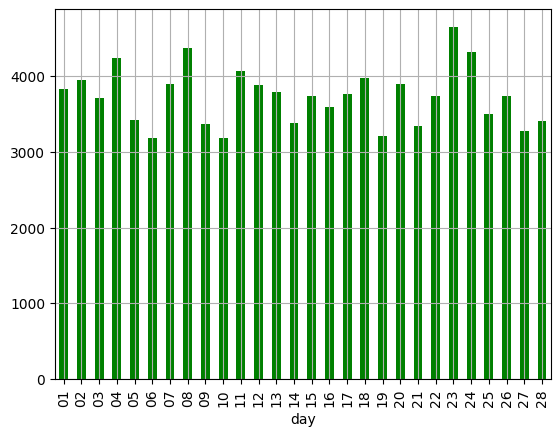

In [81]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

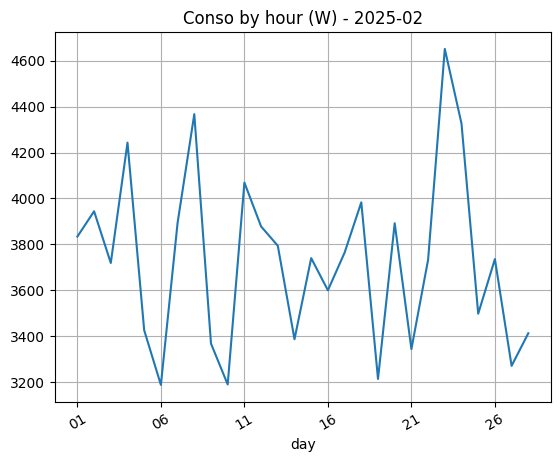

In [82]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [83]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [84]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3834,3834,3834
02,3944,3944,3944
03,3719,3719,3719
04,4243,4243,4243
05,3426,3426,3426
06,3188,3188,3188
07,3894,3894,3894
08,4367,4367,4367
09,3368,3368,3368


In [85]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [86]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [87]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-05,10701,10701,10701
2024-06,96197,96197,96197
2024-07,99502,99502,99502
2024-08,117317,117317,117317
2024-09,69651,69651,69651
2024-10,73681,73681,73681
2024-11,108468,108468,108468
2024-12,113863,113863,113863
2025-01,113500,113500,113500


In [88]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [89]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [90]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
28/05/24,193
29/05/24,3092
30/05/24,3274
31/05/24,4142
01/06/24,3603
...,...
22/03/25,4206
23/03/25,3673
24/03/25,3476


In [91]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,29380,0.12,29.380,122.532335,29380,2024-05-28 22:34:47.028864,28/05/24,22,2024-05,28
1,29345,0.12,29.345,122.678480,58725,2024-05-28 22:35:16.373864,28/05/24,22,2024-05,28
2,29255,0.12,29.255,123.055888,87980,2024-05-28 22:35:45.628864,28/05/24,22,2024-05,28
3,29471,0.12,29.471,122.153982,117451,2024-05-28 22:36:15.099864,28/05/24,22,2024-05,28
4,29330,0.12,29.330,122.741221,146781,2024-05-28 22:36:44.429864,28/05/24,22,2024-05,28
...,...,...,...,...,...,...,...,...,...,...
999995,27575,0.13,27.575,130.553037,26059458780,2025-03-26 13:18:36.428864,26/03/25,13,2025-03,26
999996,28118,0.13,28.118,128.031866,26059486898,2025-03-26 13:19:04.546864,26/03/25,13,2025-03,26
999997,27599,0.13,27.599,130.439509,26059514497,2025-03-26 13:19:32.145864,26/03/25,13,2025-03,26
999998,28258,0.13,28.258,127.397551,26059542755,2025-03-26 13:20:00.403864,26/03/25,13,2025-03,26


In [92]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
28/05/24 22    0       28/05/24    22  0.12
               1       28/05/24    22  0.12
               2       28/05/24    22  0.12
               3       28/05/24    22  0.12
               4       28/05/24    22  0.12
...                         ...   ...   ...
26/03/25 13    999995  26/03/25    13  0.13
               999996  26/03/25    13  0.13
               999997  26/03/25    13  0.13
               999998  26/03/25    13  0.13
               999999  26/03/25    13  0.13

[1000000 rows x 3 columns]

In [93]:
groupallbyday.indices.keys()

dict_keys(['28/05/24', '29/05/24', '30/05/24', '31/05/24', '01/06/24', '02/06/24', '03/06/24', '04/06/24', '05/06/24', '06/06/24', '07/06/24', '08/06/24', '09/06/24', '10/06/24', '11/06/24', '12/06/24', '13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/0

In [94]:
groupallbydayhours.indices.keys()

dict_keys([('28/05/24', '22'), ('28/05/24', '23'), ('29/05/24', '22'), ('29/05/24', '23'), ('29/05/24', '00'), ('29/05/24', '01'), ('29/05/24', '02'), ('29/05/24', '03'), ('29/05/24', '04'), ('29/05/24', '05'), ('29/05/24', '06'), ('29/05/24', '07'), ('29/05/24', '08'), ('29/05/24', '09'), ('29/05/24', '10'), ('29/05/24', '11'), ('29/05/24', '12'), ('29/05/24', '13'), ('29/05/24', '14'), ('29/05/24', '15'), ('29/05/24', '16'), ('29/05/24', '17'), ('29/05/24', '18'), ('29/05/24', '19'), ('29/05/24', '20'), ('29/05/24', '21'), ('30/05/24', '22'), ('30/05/24', '23'), ('30/05/24', '00'), ('30/05/24', '01'), ('30/05/24', '02'), ('30/05/24', '03'), ('30/05/24', '04'), ('30/05/24', '05'), ('30/05/24', '06'), ('30/05/24', '07'), ('30/05/24', '08'), ('30/05/24', '09'), ('30/05/24', '10'), ('30/05/24', '11'), ('30/05/24', '12'), ('30/05/24', '13'), ('30/05/24', '14'), ('30/05/24', '15'), ('30/05/24', '16'), ('30/05/24', '17'), ('30/05/24', '18'), ('30/05/24', '19'), ('30/05/24', '20'), ('30/05/2

In [95]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
28/05/24,193,193
29/05/24,3092,3092
30/05/24,3274,3274
31/05/24,4142,4142
01/06/24,3603,3603
...,...,...
22/03/25,4206,4206
23/03/25,3673,3673
24/03/25,3476,3476


In [96]:
grp_by_day['kWh'].cumsum()

days
28/05/24        193
29/05/24       3285
30/05/24       6559
31/05/24      10701
01/06/24      14304
             ...   
22/03/25     987326
23/03/25     990999
24/03/25     994475
25/03/25     998345
26/03/25    1000000
Name: kWh, Length: 303, dtype: int64

In [97]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
28/05/24 22      61
         23     132
29/05/24 00     132
         01     123
         02     133
...             ...
26/03/25 09     178
         10     134
         11     133
         12     182
         13      54

[7240 rows x 1 columns]

In [98]:
grp_by_dayhours['kWh'].cumsum()

days      hours
28/05/24  22            61
          23           193
29/05/24  00           325
          01           448
          02           581
                    ...   
26/03/25  09        999497
          10        999631
          11        999764
          12        999946
          13       1000000
Name: kWh, Length: 7240, dtype: int64

In [99]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
28/05/24 22      61      61    NaN
         23     132     193   71.0
29/05/24 00     132     132    NaN
         01     123     255   -9.0
         02     133     388   10.0
...             ...     ...    ...
26/03/25 09     178    1152   85.0
         10     134    1286  -44.0
         11     133    1419   -1.0
         12     182    1601   49.0
         13      54    1655 -128.0

[7240 rows x 3 columns]

In [100]:
today, grp_by_dayhours.loc[today]

('26/03/25',
        kWh  cumsum   diff
 hours                    
 00     143     143    NaN
 01     117     260  -26.0
 02     107     367  -10.0
 03      94     461  -13.0
 04     106     567   12.0
 05     105     672   -1.0
 06     106     778    1.0
 07     103     881   -3.0
 08      93     974  -10.0
 09     178    1152   85.0
 10     134    1286  -44.0
 11     133    1419   -1.0
 12     182    1601   49.0
 13      54    1655 -128.0)

Text(0.5, 1.0, 'Cumul journalier')

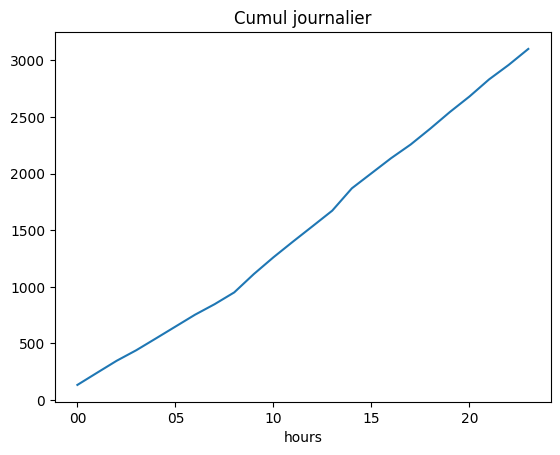

In [101]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

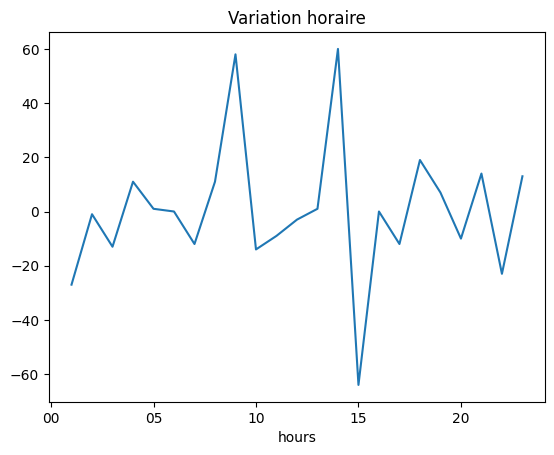

In [102]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [103]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [104]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.774494
min        0.193000
25%        3.127000
50%        3.482000
75%        3.782000
max        4.920000
Name: kWh, dtype: float64

In [105]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '303 days')

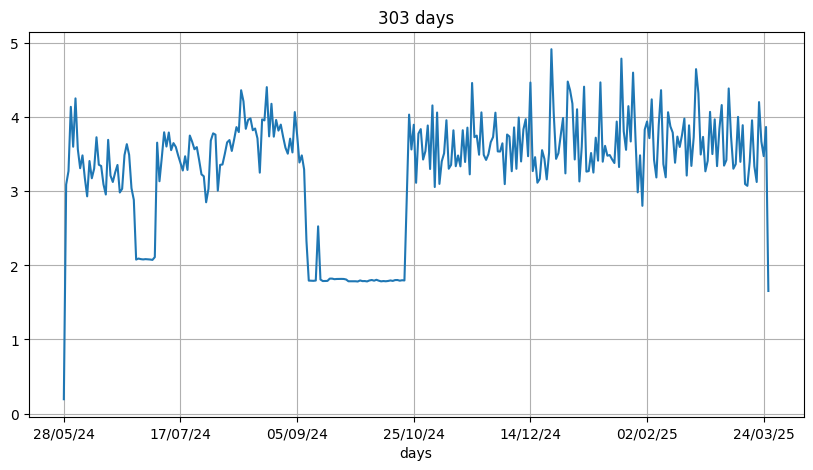

In [106]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

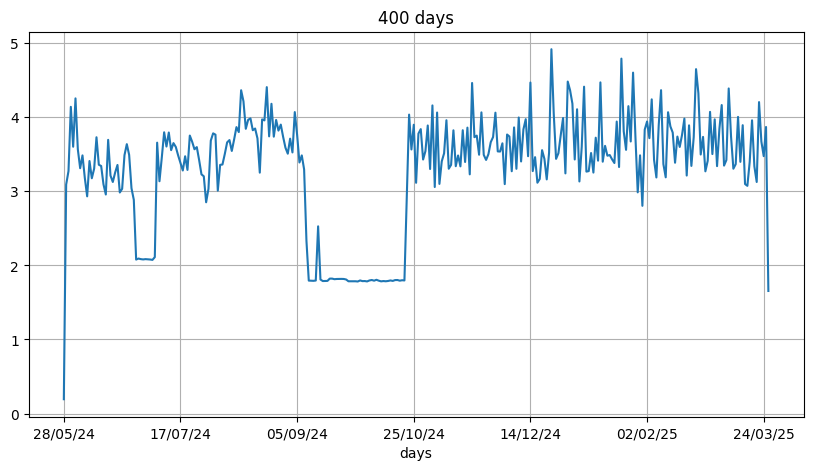

In [107]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [108]:
df_grp['kWh']

days
28/05/24    0.193
29/05/24    3.092
30/05/24    3.274
31/05/24    4.142
01/06/24    3.603
            ...  
22/03/25    4.206
23/03/25    3.673
24/03/25    3.476
25/03/25    3.870
26/03/25    1.655
Name: kWh, Length: 303, dtype: float64

In [109]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.774494
min,0.193000
25%,3.127000
50%,3.482000
75%,3.782000
max,4.920000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

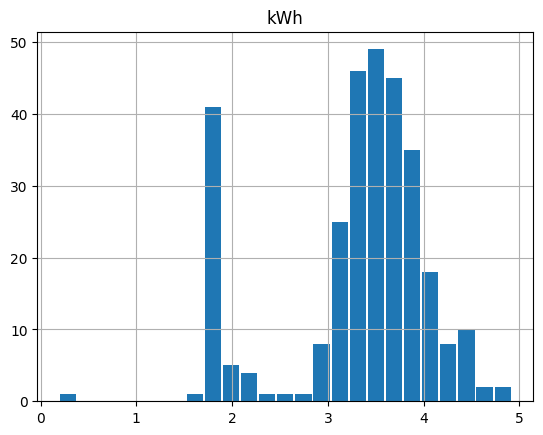

In [110]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [111]:
df_grp.tail(span)['kWh']

days
28/05/24    0.193
29/05/24    3.092
30/05/24    3.274
31/05/24    4.142
01/06/24    3.603
            ...  
22/03/25    4.206
23/03/25    3.673
24/03/25    3.476
25/03/25    3.870
26/03/25    1.655
Name: kWh, Length: 303, dtype: float64

# Conso par heure

In [112]:
day

'26/03/25'

In [113]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,143,143,NaN
01,117,260,-26.0
02,107,367,-10.0
03,94,461,-13.0
04,106,567,12.0
05,105,672,-1.0
06,106,778,1.0
07,103,881,-3.0
08,93,974,-10.0


In [114]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


14

In [115]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 15)

In [116]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [117]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
Name: days, dtype: float64

In [119]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [120]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 00 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     14 non-null     int64  
 1   cumsum  14 non-null     int64  
 2   diff    13 non-null     float64
 3   days    14 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 560.0+ bytes


In [121]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
Name: days, dtype: float64

In [122]:
day

'26/03/25'

In [123]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,143,143,NaN,1.0
01,117,260,-26.0,2.0
02,107,367,-10.0,3.0
03,94,461,-13.0,4.0
04,106,567,12.0,5.0
05,105,672,-1.0,6.0
06,106,778,1.0,7.0
07,103,881,-3.0,8.0
08,93,974,-10.0,9.0


Text(0.5, 1.0, '26/03/25')

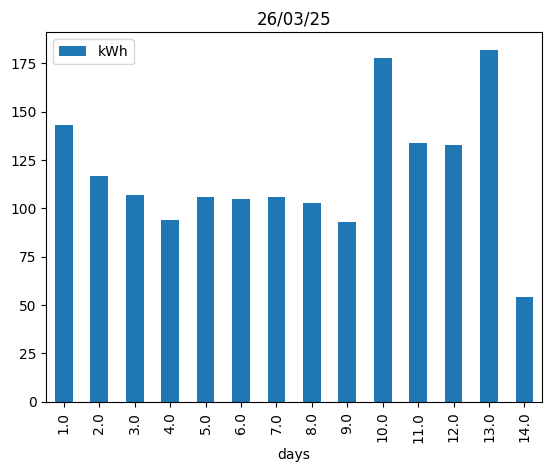

In [124]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [125]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13'],
      dtype='object', name='hours')

# Conso du jour


In [126]:

grp_by_dayhours.count()

kWh       7240
cumsum    7240
diff      6937
days        14
dtype: int64

In [127]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00     135
01     134
02     138
03     110
04     109
05     110
06     108
07     108
08     109
09     110
10     101
11     167
12     143
13     138
14     133
15    1014
16     529
17     136
18     212
19     168
20     239
21     243
22     280
23     246
Name: kWh, dtype: int64

In [128]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
26/03/25  1.655


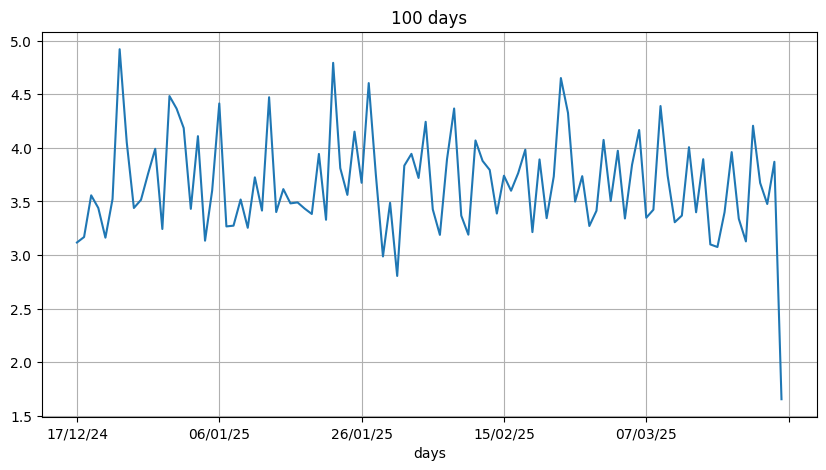

In [129]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [130]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

81.56518650054932


# Today

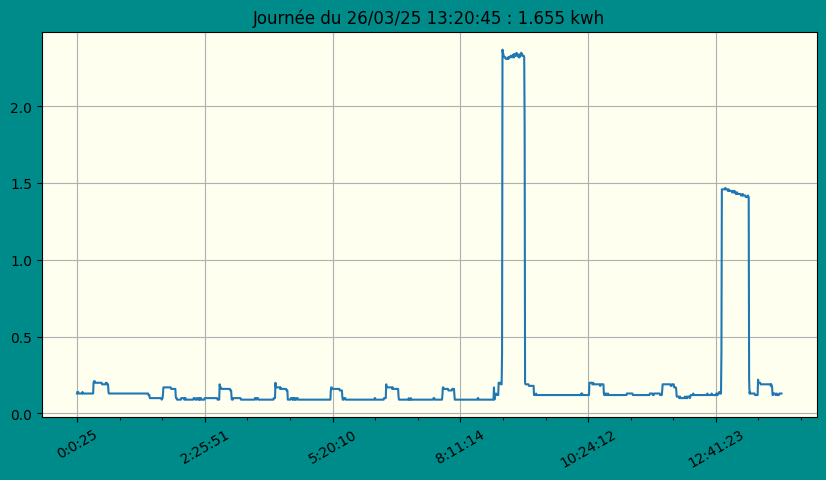

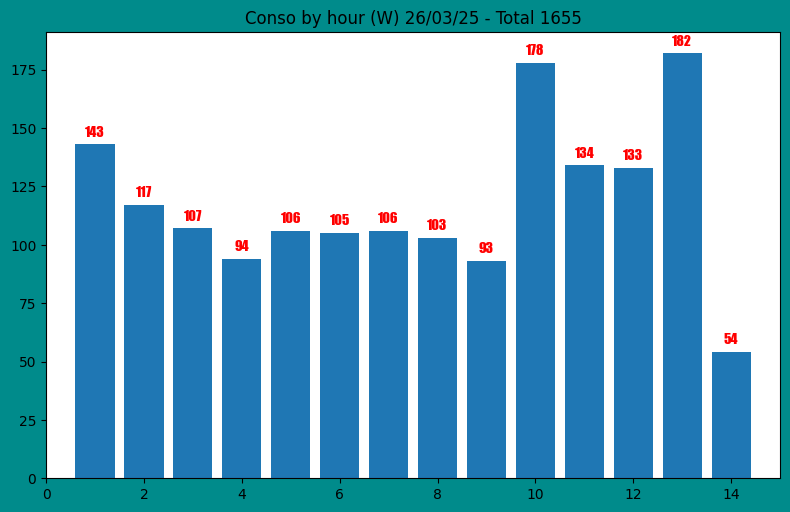

In [131]:
show(today,bgcolor='ivory')
conso_by_hour(today)

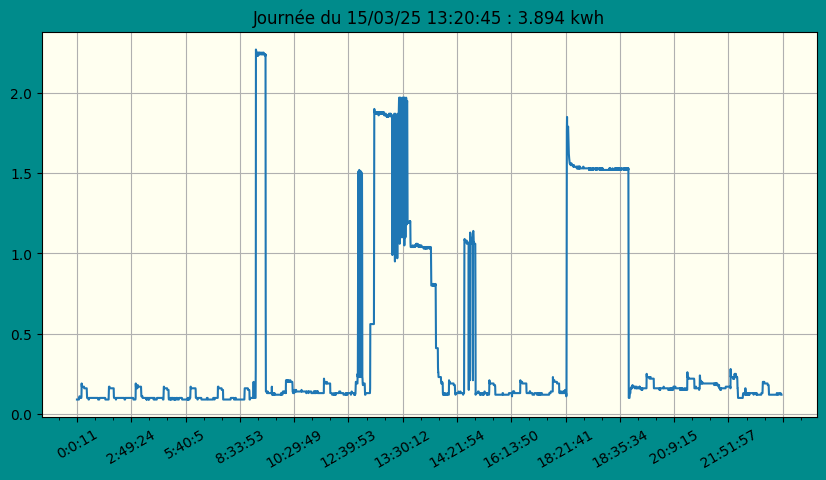

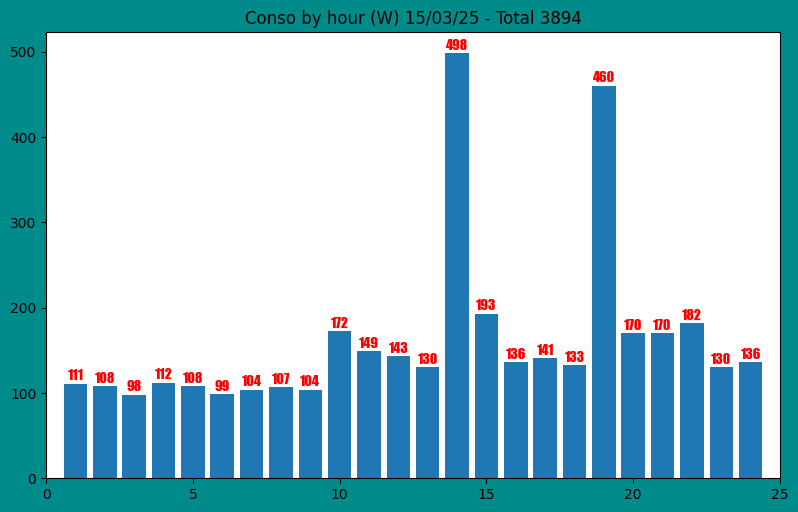

In [132]:
day = '15/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4920)

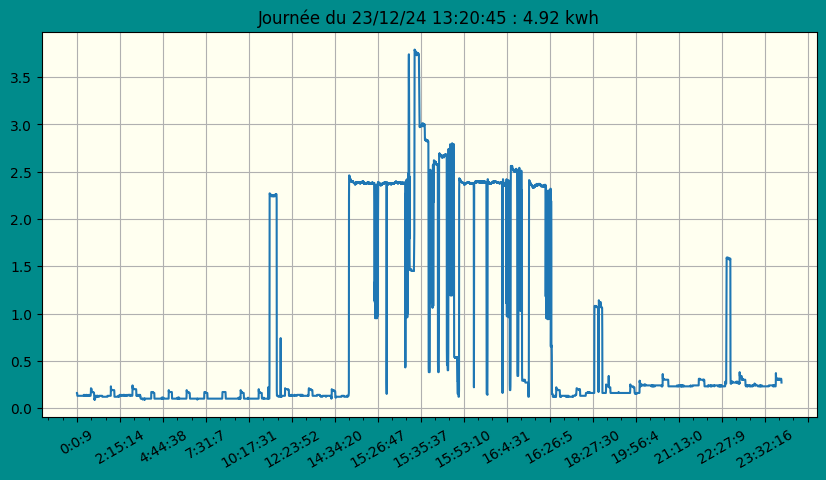

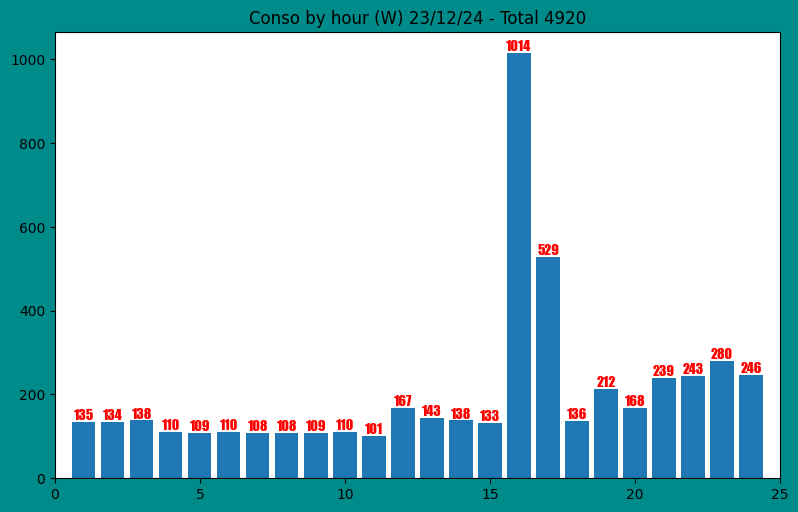

In [133]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

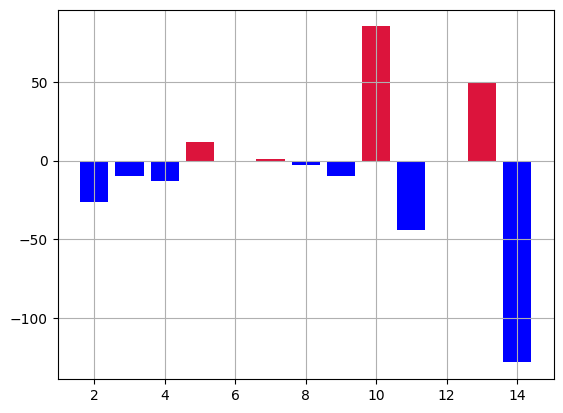

In [134]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

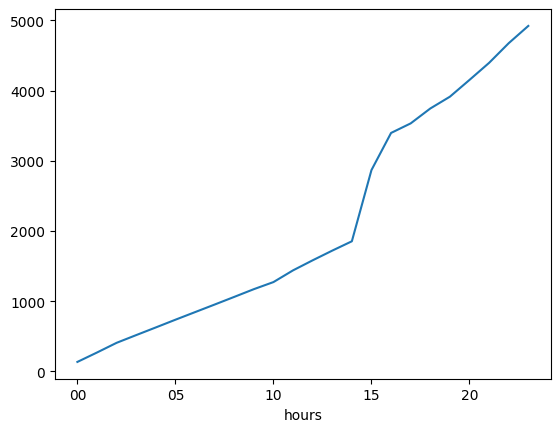

In [135]:
data.cumsum().plot()


<Axes: xlabel='hours'>

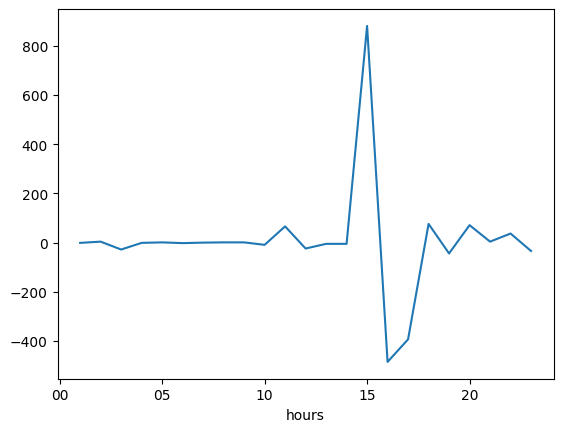

In [136]:
# evolution par heure
data.diff().plot()

In [137]:
data.diff().describe()

count     23.000000
mean       4.826087
std      232.228855
min     -485.000000
25%      -16.500000
50%       -1.000000
75%        4.000000
max      881.000000
Name: kWh, dtype: float64

<Axes: >

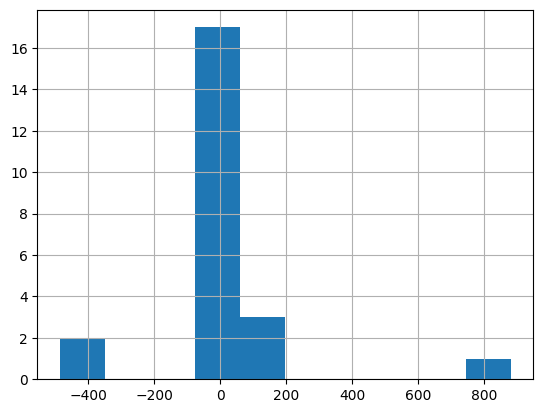

In [138]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [139]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [140]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

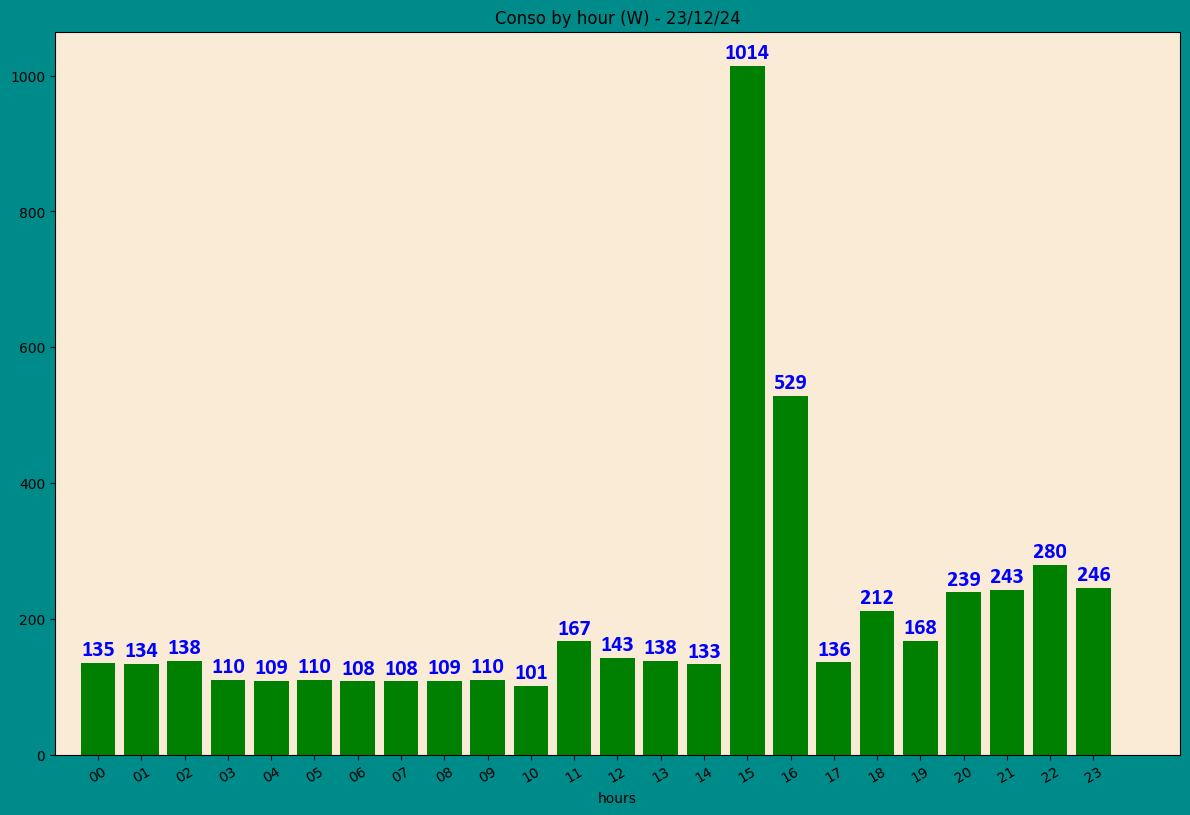

In [141]:
day,conso_byhour(day)

In [142]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


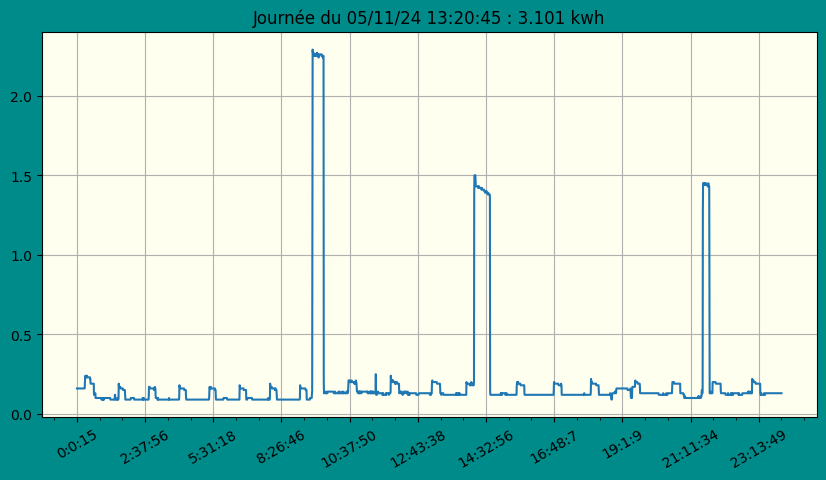

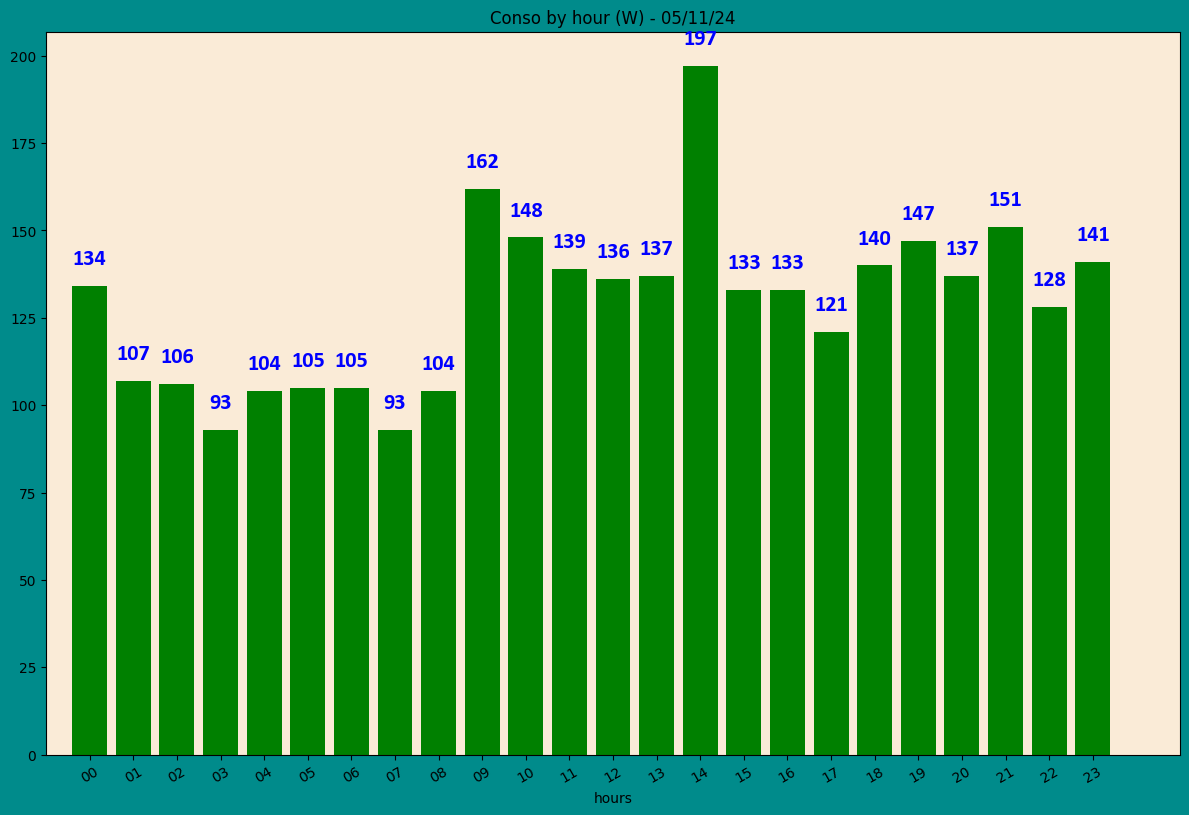

In [143]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [144]:
month

,day,hours,months,kWh
802880,01,00,2025-02,0.17
802881,01,00,2025-02,0.17
802882,01,00,2025-02,0.17
802883,01,00,2025-02,0.17
802884,01,00,2025-02,0.17
...,...,...,...,...
907341,28,23,2025-02,0.17
907342,28,23,2025-02,0.17
907343,28,23,2025-02,0.17
907344,28,23,2025-02,0.17


In [145]:
month.describe()


,kWh
count,104466.000000
mean,0.334573
std,0.555147
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

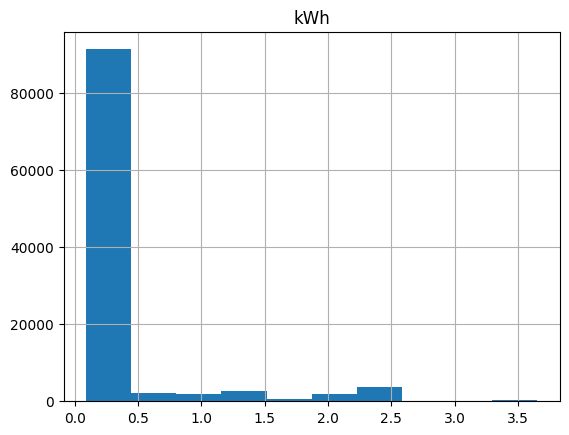

In [146]:
month.hist()

<Axes: >

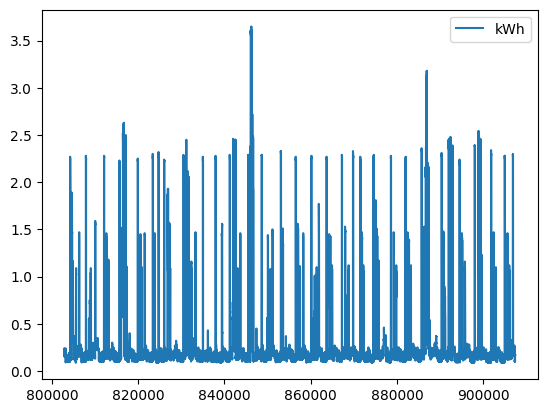

In [147]:
month.plot()

In [148]:
# index with max conso in this month
month.idxmax().kWh

np.int64(846219)

In [149]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       903933
hours     806539
months    802880
kWh       846219
dtype: int64

In [150]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [151]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
28/05/24 22      61      61    NaN   NaN
         23     132     193   71.0   NaN
29/05/24 00     132     132    NaN   NaN
         01     123     255   -9.0   NaN
         02     133     388   10.0   NaN
...             ...     ...    ...   ...
26/03/25 09     178    1152   85.0  10.0
         10     134    1286  -44.0  11.0
         11     133    1419   -1.0  12.0
         12     182    1601   49.0  13.0
         13      54    1655 -128.0  14.0

[7240 rows x 4 columns]

In [152]:
month

,day,hours,months,kWh
802880,01,00,2025-02,0.17
802881,01,00,2025-02,0.17
802882,01,00,2025-02,0.17
802883,01,00,2025-02,0.17
802884,01,00,2025-02,0.17
...,...,...,...,...
907341,28,23,2025-02,0.17
907342,28,23,2025-02,0.17
907343,28,23,2025-02,0.17
907344,28,23,2025-02,0.17


In [153]:
month.idxmax()


day       903933
hours     806539
months    802880
kWh       846219
dtype: int64

In [154]:
month.loc[month.idxmax().kWh]


day            12
hours          13
months    2025-02
kWh          3.65
Name: 846219, dtype: object

In [155]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       114
          01       112
          02        97
          03       111
          04       112
          05       110
          06        97
          07       110
          08       159
          09       143
          10       134
          11       148
          12       144
          13       200
          14       142
          15       189
          16       161
          17       148
          18       142
          19       166
          20       226
          21       173
          22       158
          23       117
Name: kWh, dtype: int64

In [156]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'20'

<Axes: xlabel='days,hours'>

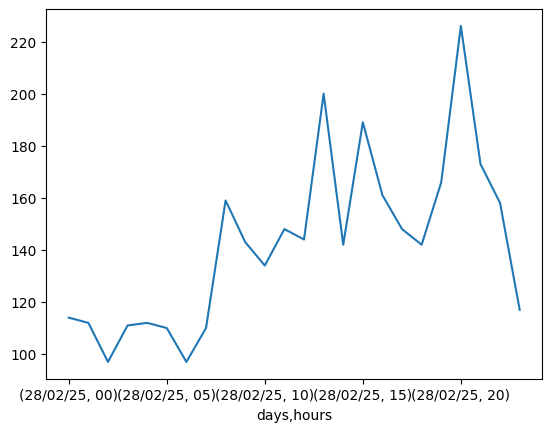

In [157]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [158]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [159]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [160]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [161]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB